In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime

matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

In [3]:
import nsfg
df = nsfg.ReadFemPreg()


In [4]:
live = df[df.outcome == 1]
len(live)

9148

In [5]:
firsts = df[df.birthord==1]
others = df[df.birthord>1]
len(firsts), len(others)

(4413, 4735)

In [6]:
a = firsts.prglngth.mean()
b = others.prglngth.mean()

c = (a - b)*168.0

print("Mean pregnancy length for first borns: {}".format(a))
print("Mean pregnancy length for others: {}".format(b))
print("Difference between mean first and others pregnancy lengths in hrs: {}".format(c))

Mean pregnancy length for first borns: 38.60095173351461
Mean pregnancy length for others: 38.52291446673706
Difference between mean first and others pregnancy lengths in hrs: 13.11026081862832


In [7]:
def get_value(vals):
    import random
    pval = random.uniform(0,100)
    #print(pval)
    return np.percentile(vals,pval)


def get_group(vals, numberofsubjects):
    """Returns a pandas series."""
    import random
    a = list()
    for i in range(numberofsubjects):
        try:
            b = get_value(vals)
            a.append(b)
        except:
            pass
    c = pd.Series(a)
    return c

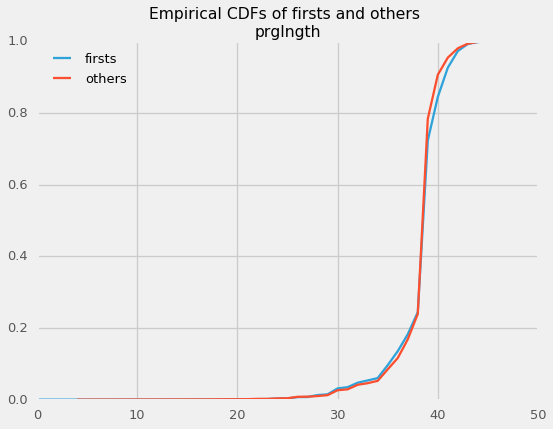

In [8]:

firsts_data = firsts.prglngth.value_counts(normalize=True).sort_index().cumsum()
others_data = others.prglngth.value_counts(normalize=True).sort_index().cumsum()

dfdata = pd.DataFrame({'firsts': firsts_data,
                     'others': others_data})
dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6), title = "Empirical CDFs of firsts and others \n" + 
           "prglngth");

In [9]:
firsts_prglngth_vals = firsts.prglngth.values
others_prglngth_vals = others.prglngth.values

firstssamp = get_group(firsts_prglngth_vals, 150000)
otherssamp = get_group(others_prglngth_vals, 150000)

In [10]:
(firstssamp > otherssamp).values.mean()


0.37891333333333332

## <font color='steelblue'>The Estimation Game</font>

```
Let’s play a game. I think of a distribution, and you have to guess what it is. I’ll give you two hints: it’s a normal distribution, and here’s a random sample drawn from it:
[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

What do you think is the mean parameter, µ, of this distribution?

One choice is to use the sample mean, x, as an estimate of µ. In this example, x is 0.155, so it would be reasonable to guess µ = 0.155. This process is called estimation, and the statistic we used (the sample mean) is called an estimator.
```

In [35]:
nums = [-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

numser = pd.Series(nums)
print(numser.mean(),numser.std())


0.15516666666666667 1.8933573795421366


In [13]:
import scipy
results = scipy.stats.bayes_mvs(numser.as_matrix())
results

(Mean(statistic=0.15516666666666667, minmax=(-1.4023849490394598, 1.7127182823727924)),
 Variance(statistic=5.9746702777777765, minmax=(1.6190790450036288, 15.647649794494102)),
 Std_dev(statistic=2.2519897075579607, minmax=(1.2724303694126562, 3.9557110352620684)))

If there are no outliers, the sample mean minimizes the **mean squared error** (MSE). That is, if we play the game many times, and each time compute the error $\bar{x} - \mu$, the sample mean minimizes:

$
MSE = \frac{1}{m} \sum (\bar{x} - \mu)^{2}
$

where $m$ is the number of times you play the estimation game, not to be confused with $n$, which is the size of the sample used to compute $\bar{x}$.



In [14]:
import math

def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return math.sqrt(mse)

In [21]:
def Estimate1(n=7, m=1000):
    import random
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))

Again, $n$ is the size of the sample, and $m$ is the number of times we play the game. ```means``` is the list of estimates based on $\bar{x}$. ```medians``` is the list of medians. 

In the function ```RMSE```, ```estimates``` is the list of estimates, ```actual``` is the actual thing being estimated. In practice, of course, we don't know ```actual```; if we did, we wouldn't have to estimate it. The purpose of the experiment is to compare the performance of the two estimators.

In [22]:
Estimate1()

rmse xbar 0.3837896535522685
rmse median 0.4625434945810025


When I ran this code, the RMSE of the sample mean was 0.3837, which means that if we $\bar{x}$ to estimate the mean of this distribution, based on a sample with $n=7$, we should expect to be off by 0.3837 on average. Using the median to estimate the mean yields RMSE of 0.46254, which confirms that $\bar{x}$ yields lower RMSE, at least for this example.


Minimizing MSE is a nice property, but it's not always the best strategy. For example, suppose we are estimating the distribution of wind speeds at a building site. If the estimate is too high, we might overbuild the structure, increasing its cost. But if it's too low, the building might collapse. Because cost as a function of error is not symmetric, minimizing MSE is not the best strategy.

AS another exmaple, suppose I roll three six-sided dice and ask you to predict the total. If you get it exactly right, you get a prize; otherwise you get nothing. In this case the value that minimizes the MSE is 10.5

In [25]:
def Dice_3_6(trials = 800000, n=3):
    import random
    totals = []
    dicevalues = range(1,7)
    for _ in range(trials):
        rolls = [random.choice(dicevalues) for i in range(n)]
        total = np.sum(rolls)
        totals.append(total)

    print('average of the total of rolling three dice', np.mean(totals))
    totalsser = pd.Series(totals)
    print(totalsser.value_counts(normalize=True))

In [26]:
Dice_3_6()

average of the total of rolling three dice 10.50150125
10    0.125825
11    0.125584
9     0.115679
12    0.115414
13    0.097589
8     0.096729
14    0.069440
7     0.069282
6     0.046294
15    0.046170
5     0.027856
16    0.027690
17    0.013705
4     0.013491
3     0.004666
18    0.004586
dtype: float64


In this case the value that minimizes the MSE is 10.5, but that would be a bad guess, becauase the total of three dice is never 10.5. For this game, you want an estimator tha thas the highest chance of being right, which is a **maximum likelihood estimator** (MLE). If you pick 10 or 11, your chance of winning is 1 in 8, and that's the best you can do.

## <font color='steelblue'>Guess the variance</font>


I'm thinking of a distribution. It's a normal distribution, and here's a (familiar) sample:

[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

What do you think is the variance,  $\sigma^{2}$  of my distribution? Again, the obvious choice is to use the sample variance,  $S^{2}$ , as an estimator:

$
S^{2} = \frac{1}{n} \sum (x_{i} - \bar{x})^{2} 
$

For large samples,  $S^{2}$  is an adequate estimator, but for small samples it tends to be too low. Because of this unforunate property, it is called a biased estimator. An estimator is unibiased if the expected total (or mean) error, after many iterations of the estimation game, is 0.
Fortunately, there is another simple statistic that is an ubiased estimator of  $\sigma^{2}$ :

$
S^{2}_{n-1} = \frac{1}{n-1}\sum (x_{i} - \bar{x})^{2}
$

For an explanation of why  $S^{2}$  is biased, and a proof that $S^{2}_{n-1}$  is unbiased, see http://wikipedia.org/wiki/Bias_of_an_estimator
The biggest problem with this estimator is that its name and symbol are used inconsistently. The name "sample variance" can refer to either  $S^{2}$  or  $S^{2}_{n-1}$ , and the symbol  $S^{2}$  is used for either or both.
Here is a function that simulates the estimation game and tests the performance of  $S^{2}$  and  $S^{2}_{n-1}$ :


In [27]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [30]:
import random
def Estimate2(n=7, m=100000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))

Again, $n$ is the sample size and $m$ is the number of times we play the game. ```np.var``` computes $S^{2}$ by default and $S^{2}_{n-1}$ if you provide the argument ```ddof=1```, which stands for delta degrees of freedom. I won't explain that term, but you can read about it at http://en.wikipedia.org/wiki/Degrees_of_freedom .
```MeanError``` computes the mean difference between the estimate and the actual value.

In [31]:
Estimate2()

mean error biased -0.141332265273
mean error unbiased 0.00177902384842


When I ran this code, theb mean error for $S^{2}$ was -0.141. As expected, this biased estimator tends to be too low. For $S_{n-1}^{2}$, the mean error was 0.00177, much much smaller. As ```m``` increases, we expect the mean error for $S_{n-1}^{2}$ to approach 0.

Properties like MSE and bias are long-term expectations based on many iterations of the estimation game. By running simulations like the ones in this chapter, we can compare estimators and check whether they have the desired properties.

But when you apply an estimator to real data, you just get one estimate. It would not be meaningful to say that the estimate is unbiased; being unbiased is a property of the estimator, not the estimate.

After you choose an estimator with appropriate properties, and use it to generate an estimate, the next step is to characterize the uncertainty of the estimate, which is the topic of the next section.

## <font color='steelblue'>Sampling distributions</font>

Suppose you are a scientist studying gorillas in a wildlife preserve. You want to know the average weight of the adult female gorillas in the preserve. To weigh them, you have to tranquilize them, which is dangerous, expensive, and possibly harmful to the gorillas. But if it is important to obtain this information, it might be acceptable to weigh a sample of 9 gorillas. Let's assume that hte population of the preserve is well known, so we can choose a representative sample of adult females. We could use the sample mean, $\bar{x}$, to estimate the unknown populatin mean, $\mu$.

Having weighed 9 female gorillas, you might find $\bar{x} = 90$ kg and a sample standard deviation $S = 7.5$ kg. The sample mean is an unbiased estimator of $\mu$ and in the long run it minimizes MSE. So if you report a single estimate that summarizes the results, you would report 90 kg.

But how confident should you be in this estimate? If you only weigh $n = 9$ gorillas out of a much bigger population, you might be unlucky and choose the 9 heaviest gorillas (or the 9 lightest ones) just by chance. Variation in the estimate caused by random selection is called **sampling error**.

To quantify sampling error, we can simulate the sampling process with hypothetical values of $\mu$ and $\sigma$ and see how much $\bar{x}$ varies.

Since we don't know the actual values of $\mu$ and $\sigma$ in the population, we'll use the estimates $\bar{x}$ and $S$. So the question we answer is: "If the actual values of $\mu$ and $\sigma$ were 90 kg and 7.5 kg, and we ran the same experiment many times, how much would the estimated mean, $\bar{x}$, vary?"

The following function answers that question:

In [72]:
nums = [-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]*25

numser = pd.Series(nums)
print(numser.mean(),numser.std())

0.15516666666666684 1.7341811808484566


In [73]:
import scipy
results = scipy.stats.bayes_mvs(numser.as_matrix(),alpha=.9)
results

(Mean(statistic=0.1551666666666667, minmax=(-0.079194020945820731, 0.38952735427915408)),
 Variance(statistic=3.0483011621315197, minmax=(2.5105716740177595, 3.6793754899499227)),
 Std_dev(statistic=1.7429717392530304, minmax=(1.5844783602238808, 1.9181698282346928)))

In [74]:
def SimulateSample(mu=numser.mean(), sigma=numser.std(), n = numser.shape[0], m=8000):
    means = []
    for j in range(m):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)

    meansser = pd.Series(means)
    meanscdf = meansser.value_counts(normalize=True).sort_index().cumsum()
    ci = meansser.quantile(.05), meansser.quantile(.95)
    print(ci)
    stderr = RMSE(means, mu)
    print(stderr)
    return meansser, meanscdf

In [75]:
meansser, meanscdf = SimulateSample()

(-0.075304988509063031, 0.38560190644063719)
0.1400355351394091


In each iteration, we choose $n$ values from a normal distribution with the given parameters, and compute the sample mean, ```xbar```. We run 1000 simulations and then compute the distribution, ```meanscdf``` of the estimates. The result is shown on the next slide: This distribution is called the **sampling distribution** of the estimator. It shows how much the estimates would vary if we ran the experiment over and over.

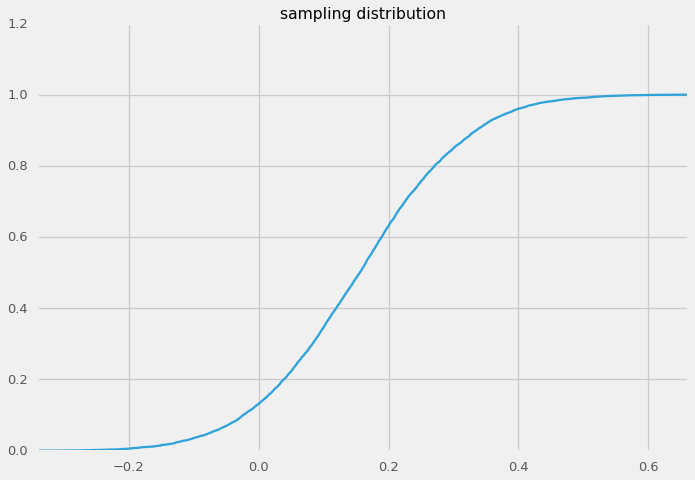

In [76]:
meanscdf.plot(drawstyle='step',title="sampling distribution");

The mean of the sampling distribution is pretty close to the hypothetical value of $\mu$, which means that the experiment yields the right answer, on average. After 1000 tries, the lowest result is -0.2, and the highest is 0.6. This range suggests that the estimate might be off by as much as 4.5.

There are two common ways to summarize the sampling distribution:

* **Standard error** (SE) is a measure of how far we expect the estimate to be off, on average. For each simulated experiment, we comput the error, $\bar{X} - \mu$, and then compute the root mean squared error (RMSE). In this example, it is roughly .14
* A **confidence interval** (CI) is a range that includes a given fraction of the sampling distribution. For example, the 90% confidence interval is the range from the 5th to the 95th percentile. In this example, the 90% is (-0.0753, 0.3856)

standard errors and confidence intervals are the source of much confusion:

* People often confuse standard error and standard deviation. Remember that standard deviation describes variability in a measured quantity; in this example, the standard deviation of gorilla weight is 7.5 kg. Standard error describes the variability in an estimate. In this example, the standard error of the mean, based on the sample of 9 measurements, is 2.44 kg. One way to remember the difference is that, as sample size increases, standard error gets smaller; standard deviation does not.
* People often think that there is a 90% probability that the actual parameter,  $\mu$, falls in the 90% confidence interval. Sadly, that is not true. If you want to make a claim like that, you have to use Bayesian methods. The sampling distribution answers a different question: it gives you a sense of how realiable an estimate is by telling you how much it would vary if you ran the experiment again.

It is important to remember that confidence intervals and standard errors only quantify sampling error; that is, error due to measuring only part of the population